## Model performance and plots

In [1]:
import sys
sys.path.append("../src")

In [2]:
import ee
import pandas as pd

import matplotlib.pyplot as plt
import geemap.eefolium as geemap

from plot_utils import plot_inference
from inf_utils import get_model_prediction
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

#### Initialize earth engine

In [3]:
ee.Initialize()

#### Model endpoint for interence generation

In [4]:
model_endpoint = "mangrove-automl-2013"

#### Data location

In [5]:
bucket = "sagemaker-gis"
test_data_path = "LANDSAT_LC08_C01_T1_SR/Year2013/test_with_coord.csv"

#### Predictions

In [6]:
%%time
y_true, y_pred, df_xy = get_model_prediction(bucket, 
                                             test_data_path, 
                                             model_endpoint,
                                             coords=["x", "y"]
                                            )

CPU times: user 8.29 s, sys: 128 ms, total: 8.42 s
Wall time: 1min 25s


#### Confusion matrix

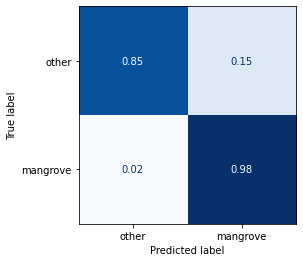

In [7]:
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, 
                                        normalize="true", 
                                        values_format=".2f",
                                        display_labels=["other", "mangrove"],
                                        colorbar=False,
                                        cmap = plt.get_cmap('Blues'));

In [8]:
print(classification_report(y_true, y_pred, target_names=["other", "mangrove"]))

              precision    recall  f1-score   support

       other       0.99      0.85      0.92      3829
    mangrove       0.75      0.98      0.85      1737

    accuracy                           0.89      5566
   macro avg       0.87      0.92      0.88      5566
weighted avg       0.91      0.89      0.89      5566



#### Prepare data for showing predictions on map

In [9]:
df_xy["y_true"] = y_true
df_xy["y_pred"] = y_pred
df_xy["geometry"] = df_xy[['x', 'y']].apply(lambda x: ee.Geometry.Point([x[0], x[1]]), axis=1)

df_correct = df_xy.loc[df_xy["y_true"] == df_xy["y_pred"]].copy()
df_incorrect = df_xy.loc[df_xy["y_true"] != df_xy["y_pred"]].copy()

#### India region

In [10]:
year = 2013
mangrove_images_landsat = ee.ImageCollection('LANDSAT/MANGROVE_FORESTS').first()

In [11]:
india_lonlat = [88.8, 21.8]
india_point = ee.Geometry.Point(india_lonlat)

In [12]:
region_image = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
    .filterBounds(india_point) \
    .filterDate(f'{year}-01-01', f'{year}-12-31') \
    .select('B[1-7]') \
    .sort('CLOUD_COVER') \
    .first()

mangrove_mask = region_image.updateMask(mangrove_images_landsat.eq(1))
non_mangrove_mask = region_image.updateMask(mangrove_mask.unmask().Not())

#### Mangrove points

In [13]:
plot_feat = {
    "zoom": 9,
    "poi": india_point
}

plot_inference(mangrove_images_landsat, df_xy, plot_feat, plot_class=1)

#### Points outside Mangrove area

In [14]:
plot_feat = {
    "zoom": 8,
    "poi": india_point
}
plot_inference(non_mangrove_mask, df_xy, plot_feat, plot_class=0)

#### Myanmar region

In [15]:
myanmar_lonlat = [98.62, 12.2]
myanmar_point = ee.Geometry.Point(myanmar_lonlat)

In [16]:
region_image = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
    .filterBounds(myanmar_point) \
    .filterDate(f'{year}-01-01', f'{year}-12-31') \
    .select('B[1-7]') \
    .sort('CLOUD_COVER') \
    .first()

mangrove_mask = region_image.updateMask(mangrove_images_landsat.eq(1))
non_mangrove_mask = region_image.updateMask(mangrove_mask.unmask().Not())

In [17]:
plot_feat = {
    "zoom": 9,
    "poi": myanmar_point
}

plot_inference(mangrove_images_landsat, df_xy, plot_feat, plot_class=1)

In [18]:
plot_feat = {
    "zoom": 8,
    "poi": myanmar_point
}
plot_inference(non_mangrove_mask, df_xy, plot_feat, plot_class=0)